# **Grover's Algorithm for Graph Coloring Problems**

## **Group - 6**

> Vandan Patel (202001023)

> Nisarg Suthar (202003030)

> Manjal Shah (202003037)
---


## **Importing from Qiskit**

In [91]:
# !pip install qiskit

from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister
from qiskit.circuit import AncillaQubit
from qiskit.providers.aer import QasmSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover

import warnings
warnings.filterwarnings('ignore')

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


In [92]:
def plot_results(result, satisfies_disagree_list):

  # Plotting results
  counts = result.circuit_results[0]
  plot = plot_histogram(counts, figsize=(int(6*len(counts.keys())**(1/2)), 8), sort='value_desc')
  ax = plot.gca()
  ax.tick_params(axis='x', which='major', labelsize=10)
  ax.set_xlabel("State", fontsize = 'x-large')
  ax.set_ylabel("Count", fontsize = 'x-large')

  # Marking correct (orange) vs. incorrect (blue) states
  correct_count = 0
  states = ax.xaxis.get_ticklabels()
  for i in range(len(states)):
    if(satisfies_disagree_list(states[i].get_text())):
      ax.containers[i][0].set(color = 'orange')
      correct_count += 1
    else:
      ax.containers[i][0].set(color = 'blue')

  leg = plot.legend(['Incorrect (' + str(len(states) - correct_count) + ' counted)', 'Correct (' + str(correct_count) + ' counted)'], fontsize = 'x-large', loc = 'upper left')
  leg.legendHandles[0].set_color('blue')
  leg.legendHandles[1].set_color('orange')

  display(plot)

## **Part 1: Grover for 2 Coloring Problems**
---


#### **Step #1: Create an initial state preparation circuit.**

This circuit needs to put all possible solutions in equal superposition. Therefore, complete the code below so that:
* There is 1 qubit per country and no classical bits.
* Each qubit is put into superposition.

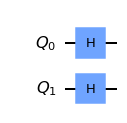

In [93]:
qr = QuantumRegister(2, 'Q') # Create a quantum register with 2 qubits

# Create a quantum circuit
prep = QuantumCircuit(qr)

# Put the qubits in superposition
prep.h(qr)

# Draw the circuit
prep.draw(output='mpl')

#### **Step #2: Create an oracle circuit.**



##### **1. Initialize the oracle circuit.**

Specifically, create a circuit such that:
* There's 4 qubits and no classical bits.
* The last qubit, $q_3$, is put into the $|-\rangle$ state.

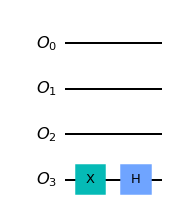

In [94]:
oqr = QuantumRegister(4, 'O') # Create a quantum register with 4 qubits

# Create a quantum circuit
oracle = QuantumCircuit(oqr)
oracle.x(oqr[-1])
oracle.h(oqr[-1])

# Draw the circuit
oracle.draw(output='mpl')

##### **2. Check if the current state is a solution.**

Specifically, apply gates as follows:
* **Flip $q_2$ if $q_0$ and $q_1$ disagree**: CX controlled by $q_0$ and targeting $q_2$ and a CX controlled by $q_1$ and targeting $q_2$. Technically, this calculates $q_2$ = XOR($q_0$, $q_1$).
* **Flip $q_3$ if $q_2$ has been activated**: CX controlled by $q_2$ and targeting $q_3$.


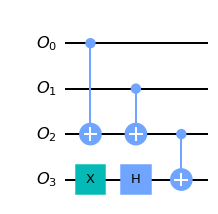

In [95]:
# Flip qubit 2 if qubits 0 and 1 disagree
oracle.cx(oqr[0], oqr[2])
oracle.cx(oqr[1], oqr[2])

# Flip qubit 3 if qubit 2 has been activated
oracle.cx(oqr[2], oqr[3])

# Draw the circuit
oracle.draw(output='mpl')

##### **3. Reset the extra bit for the next iteration.**

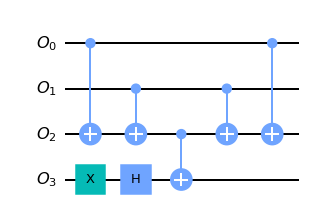

In [96]:
# Undo flipping qubit 2 if qubits 0 and 1 disagree
oracle.cx(oqr[1], oqr[2])
oracle.cx(oqr[0], oqr[2])

oracle.draw(output='mpl')

#### **Step #3: Define the problem using Qiskit's Amplification(...) function.**


In [97]:
# Function that takes a string representation of a state and checks if the bits disagree with each other
def check_disagreement(state):
  if(state[0] == state[1]):
    return False
  else:
    return True

# Setting up the problem with Qiskit's AmplificationProblem(...) function
problem = AmplificationProblem(oracle, 
                               state_preparation = prep, 
                               is_good_state = check_disagreement, 
                               objective_qubits = [0, 1])

#### **Step #4: Solve the problem using Qiskit's `Grover(...)` function.**


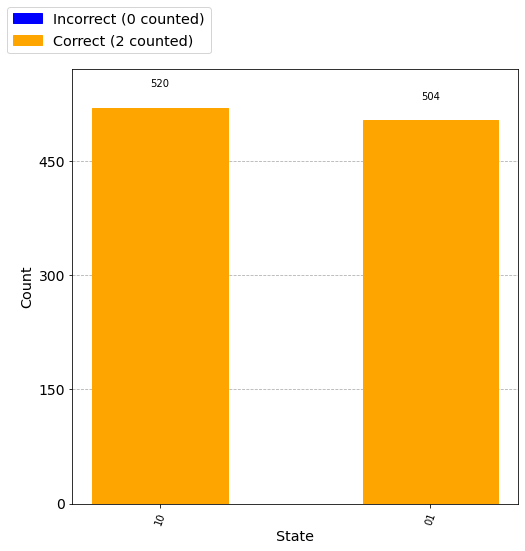

In [98]:
grover = Grover(iterations = 3, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Draw the Full Circuit.**

$U3(\pi/2, 0, \pi)$, are actually just another way to write H gates.

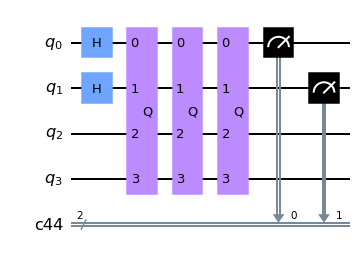

In [99]:
grover.construct_circuit(problem, measurement = True).decompose(reps = 0).draw(output='mpl')

---
### **Building General Problems**


In [100]:
variable_qubits = [0, 1]
check_qubits = [2]
output_qubit = 3
disagree_list = [[0,1]]

#### General initial state preparation circuit.


* Takes in the list of qubit numbers called `variable_qubits`.
* Initializes a quantum circuit with a qubit for every variable and no classical bits.
* Puts all the qubits in `variable_qubits` into equal superpositions.

In [101]:
def graph_color_prep(variable_qubits):
  prep = QuantumCircuit(len(variable_qubits))
  prep.h(variable_qubits)
  return prep

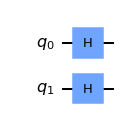

In [102]:
test_prep = graph_color_prep(variable_qubits)
test_prep.draw(output='mpl')

##### **1. Initializing a quantum circuit with the output bit in the $|-\rangle$ state.**

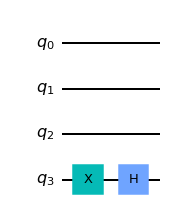

In [103]:
num_vars = len(variable_qubits)
num_checks = len(check_qubits)
num_outputs = 1

oracle = QuantumCircuit(num_vars + num_checks + num_outputs)

# Initialise output qubit to |->
oracle.x(output_qubit)
oracle.h(output_qubit)

oracle.draw(output='mpl')

##### **2. Checking if each pair of qubits in a given list, `disagree_list`, disagree with each other.**


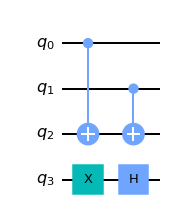

In [104]:
for i in range(len(disagree_list)):
  oracle.cx(variable_qubits[disagree_list[i][0]], check_qubits[i])
  oracle.cx(variable_qubits[disagree_list[i][1]], check_qubits[i])

oracle.draw(output='mpl')

##### **3. Flip the output bit if all disagreements are satisfied.**


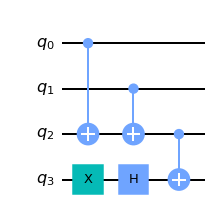

In [105]:
oracle.mct(check_qubits, output_qubit)

oracle.draw(output='mpl')

##### **4. Resetting all the extra qubits for the next iteration.**



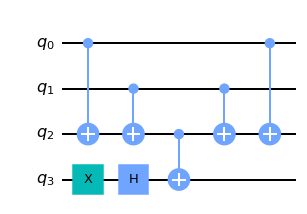

In [106]:
for i in range(len(disagree_list)):
  oracle.cx(variable_qubits[disagree_list[i][1]], check_qubits[i])
  oracle.cx(variable_qubits[disagree_list[i][0]], check_qubits[i])

oracle.draw(output='mpl')

#### **Oracle**

In [107]:
def graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit):
  oracle = QuantumCircuit(len(variable_qubits) + len(check_qubits) + 1)

  # 1. Initializing a quantum circuit with the output bit in the |−⟩ state.
  oracle.x(output_qubit)
  oracle.h(output_qubit)


  # 2. Checking if each pair of qubits in a given list, disagree_list, disagree with each other.
  for i in range(len(disagree_list)):
    oracle.cx(variable_qubits[disagree_list[i][0]], check_qubits[i])
    oracle.cx(variable_qubits[disagree_list[i][1]], check_qubits[i])

  
  # 3. Flip the output bit if all disagreements are satisfied.
  oracle.mct(check_qubits, output_qubit)


  # 4. Resetting all the extra qubits for the next iteration.
  for i in range(len(disagree_list)):
    oracle.cx(variable_qubits[disagree_list[i][1]], check_qubits[i])
    oracle.cx(variable_qubits[disagree_list[i][0]], check_qubits[i])
  
  return oracle

#### **Verifying the correct states**
* It takes in a string representation of a measured state, called `state`.
* It takes in `disagree_list`.
* It compares every pair of bits listed in the `disagree_list`.
* If any pair of bits are the same, then the function returns `False`.
* Otherwise, the function returns `True`.

In [108]:
def check_disagree_list_general(state, disagree_list):
    
    for i in range(len(disagree_list)):
      if state[disagree_list[i][0]] == state[disagree_list[i][1]]:
        return False
      
    return True

##### **1. Define the problem.**

In [109]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1]
check_qubits = [2]
output_qubit = 3
disagree_list = [[0,1]]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

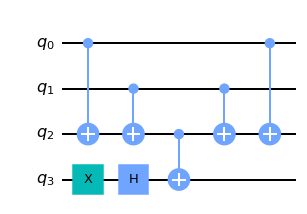

In [110]:
oracle.draw(output='mpl')

##### **2. Solve the problem.**

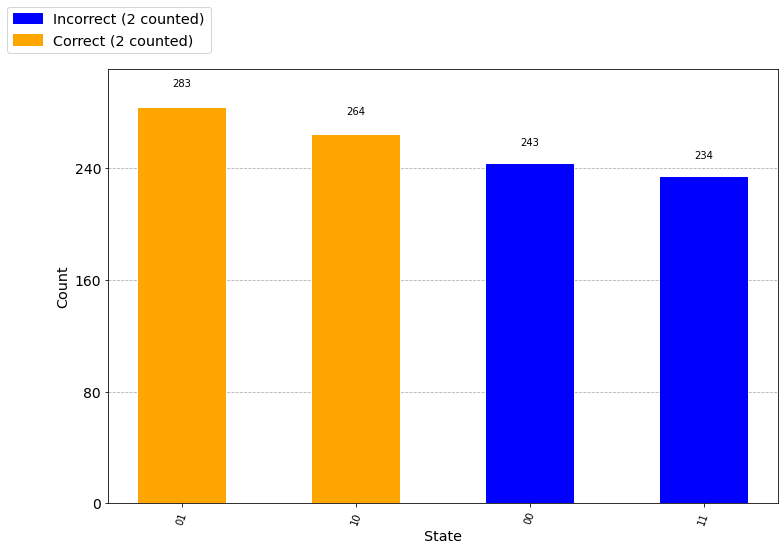

In [111]:
grover = Grover(iterations = 1, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

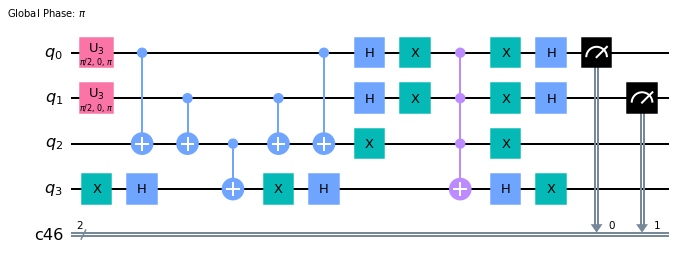

In [112]:
grover.construct_circuit(problem, measurement = True).decompose(reps = 2).draw(output='mpl')

---
### **Solving General Problems**

So far, we have solved the same problem twice. Let's use the general functions we created above to solve more complicated problems.

To start, let's solve a problem with just one more qubit (country to color) such that the countries border each other in a line as follows:

**Country 0 | Country 1 | Country 2**

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 0 and 2 can be colored the same or differently since they don't border each other.

And the correct solutions are: 010 and 101.

##### **1. Define the problem.**


In [113]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2]
check_qubits = [3, 4]
output_qubit = 5
disagree_list = [[0,1], [1,2]]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

Increase the number of iterations to get the best results. 

**NOTE**: The theoretically optimal number of iterations is roughly $\frac{\pi}{4}\sqrt{\frac{\text{Number of Possible Answers}}{\text{Number of Correct Answers}}}$. As such, for small numbers there often isn't an exact integer number of iterations that will give 100% correct solutions. Instead, the game is to start at something close to this value and tweak it until you get the correct answer most of the time.

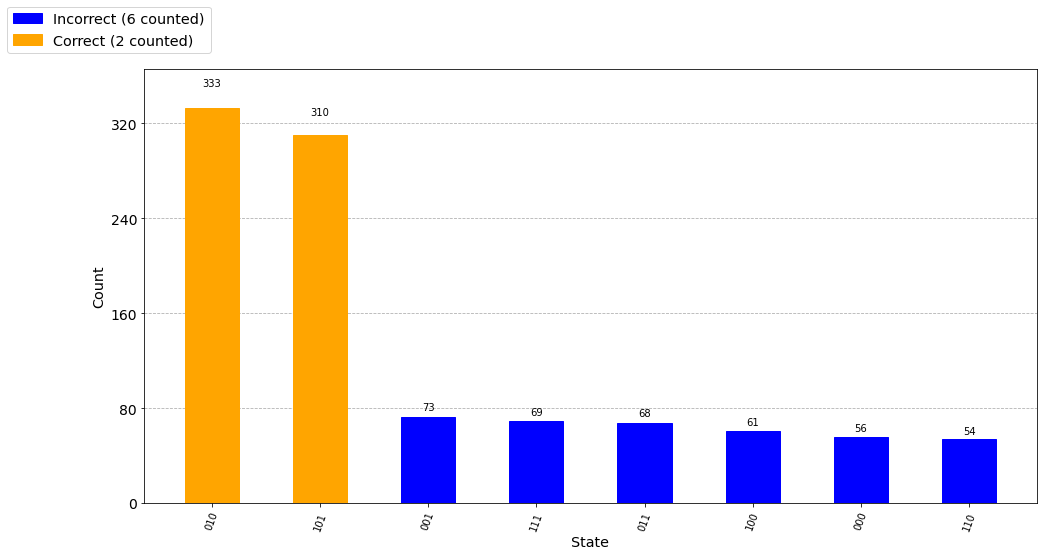

In [114]:
grover = Grover(iterations = 2, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

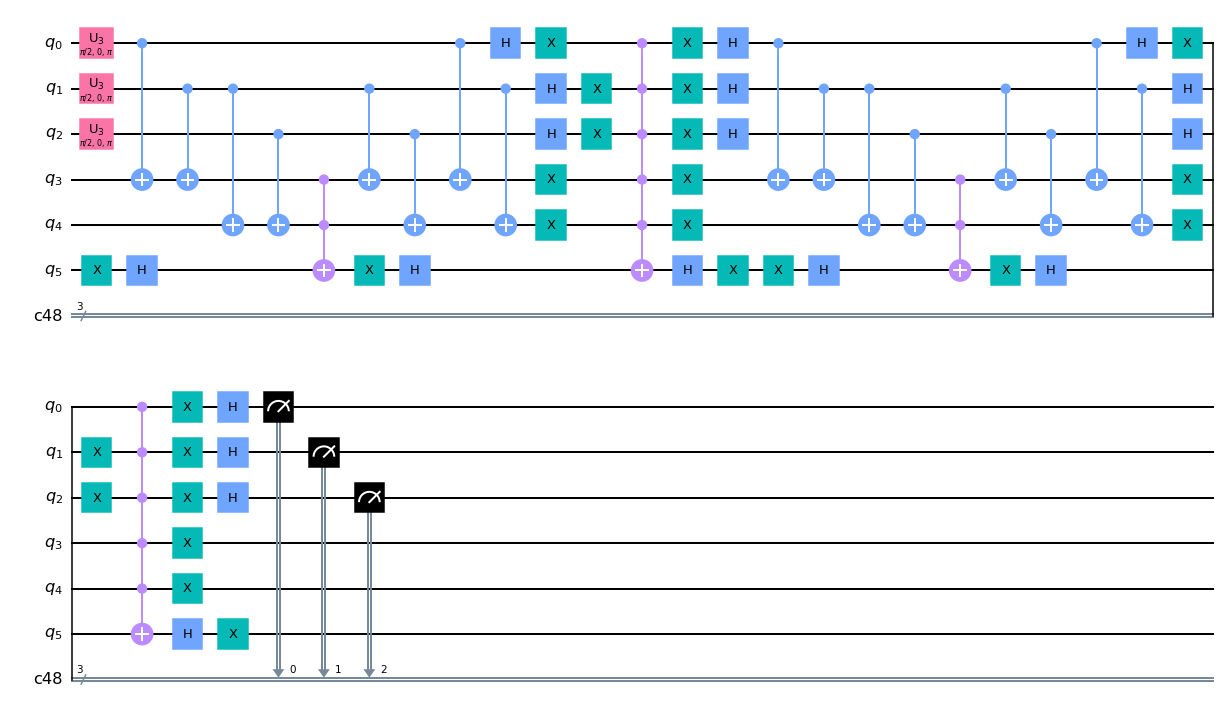

In [115]:
grover.construct_circuit(problem, measurement = True).decompose(reps = 2).draw(output='mpl')


**Country 0 | Country 1 | Country 2 | Country 3**

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 2 and 3 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

And the correct solutions are: 0101 and 1010

##### **1. Define the problem.**

In [116]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3]
check_qubits = [4, 5, 6]
output_qubit = 7
disagree_list = [[0,1], [1,2], [2,3]]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

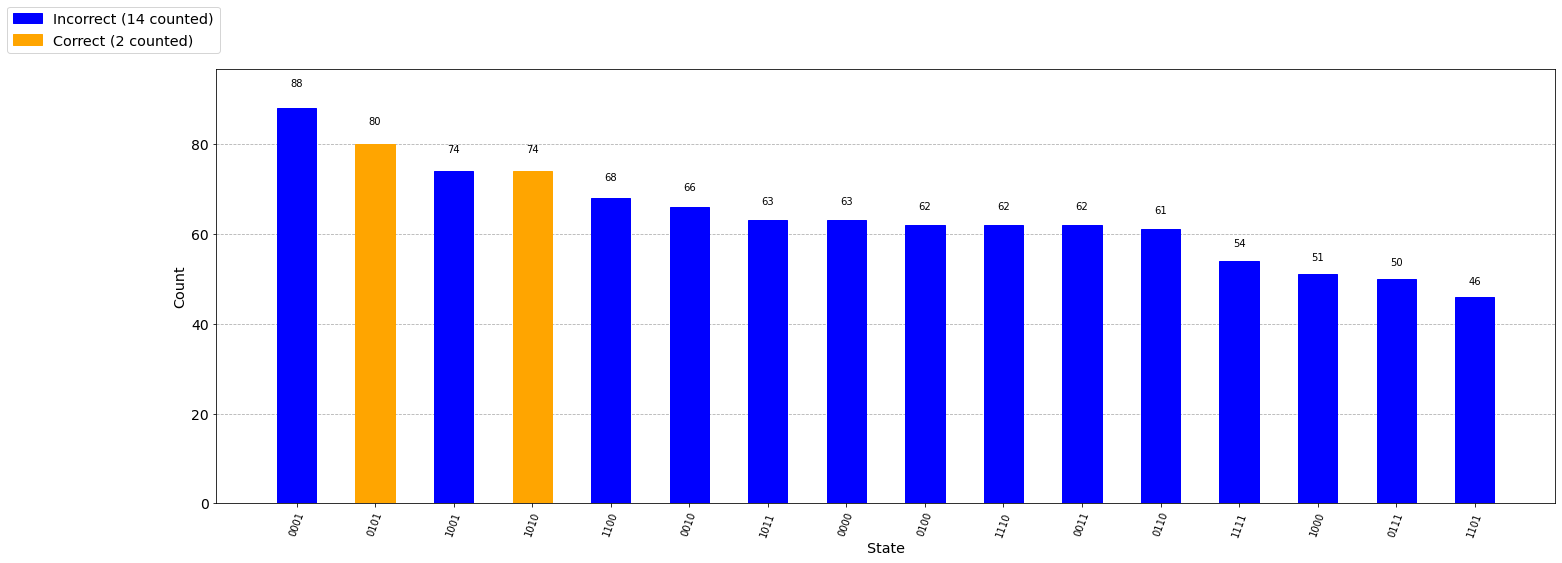

In [117]:
grover = Grover(iterations = 4, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

**Country 0 | Country 1 | Country 2**

**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Country 3**


This means that:
* Countries 0 and 1 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 1 and 3 must be colored differently.
* Countries 2 and 3 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

This problem is particularly interesting since *there are no correct solutions with 2 colors*.

##### **1. Define the problem.**

In [118]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3]
check_qubits = [4, 5, 6, 7]
output_qubit = 8
disagree_list = [[0,1], [1,2], [1,3], [2,3]]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

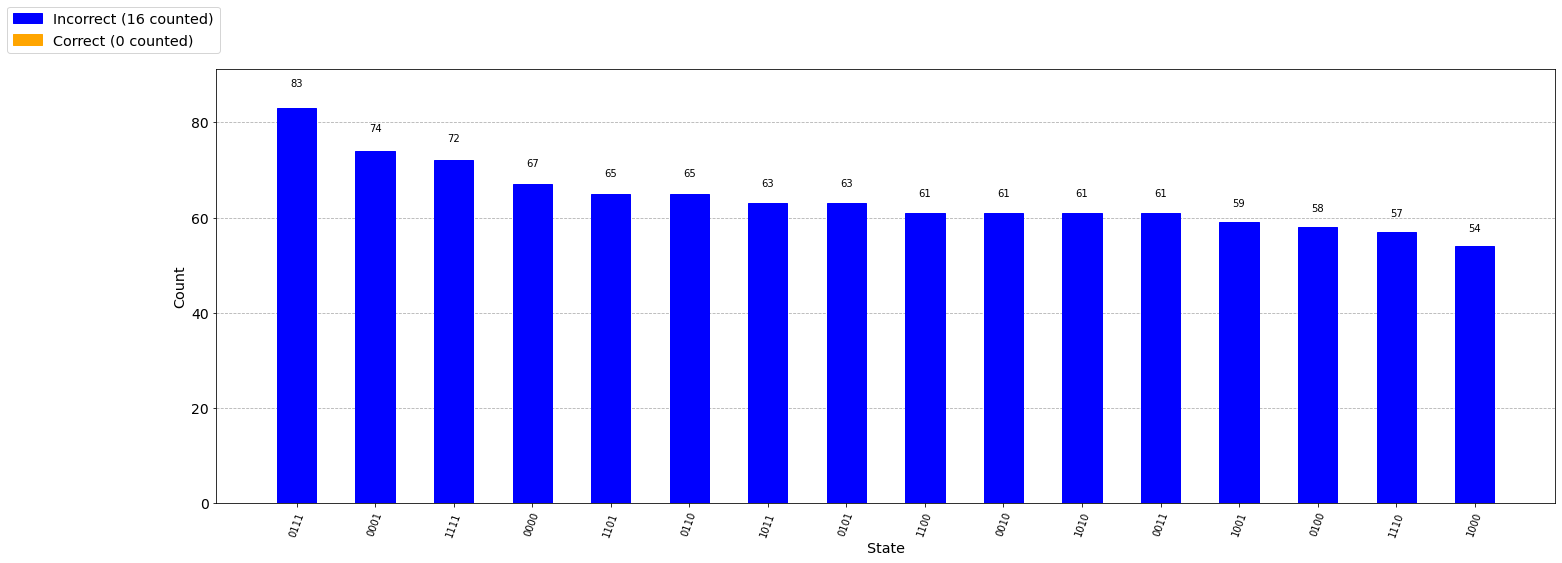

In [119]:
grover = Grover(iterations = 1, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Overconstrained and Underconstrained Problems**

This is an example of an **overconstrained problem** where there are so many constraints that there are actually *no correct answers*. Every algorithm reacts differently to these types of problems. Can you determine what Grover's algorithm is doing using the results above and your understanding of the algorithm? This will be one of the questions to answer in your project summary.

Technically, all of the problems we have seen so far have been **underconstrained problems** because they had few enough constraints to allow for *multiple correct answers*.


To wrap up, solve the following problem involving 6 countries:

**Country 0 | Country 1 | Country 2**

**Country 3 | Country 4 | Country 5**

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 0 and 3 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 1 and 4 must be colored differently.
* Countries 2 and 5 must be colored differently.
* Countries 3 and 4 must be colored differently.
* Countries 4 and 5 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

##### **1. Define the problem.**

In [120]:
# DEFINE THE VARIABLES
variable_qubits = [0,1,2,3,4,5]
check_qubits = [6,7,8,9,10,11,12]
output_qubit = 13
disagree_list = [[0,1], [1,2], [0,3], [1,4], [2,5], [3,4], [4,5]]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

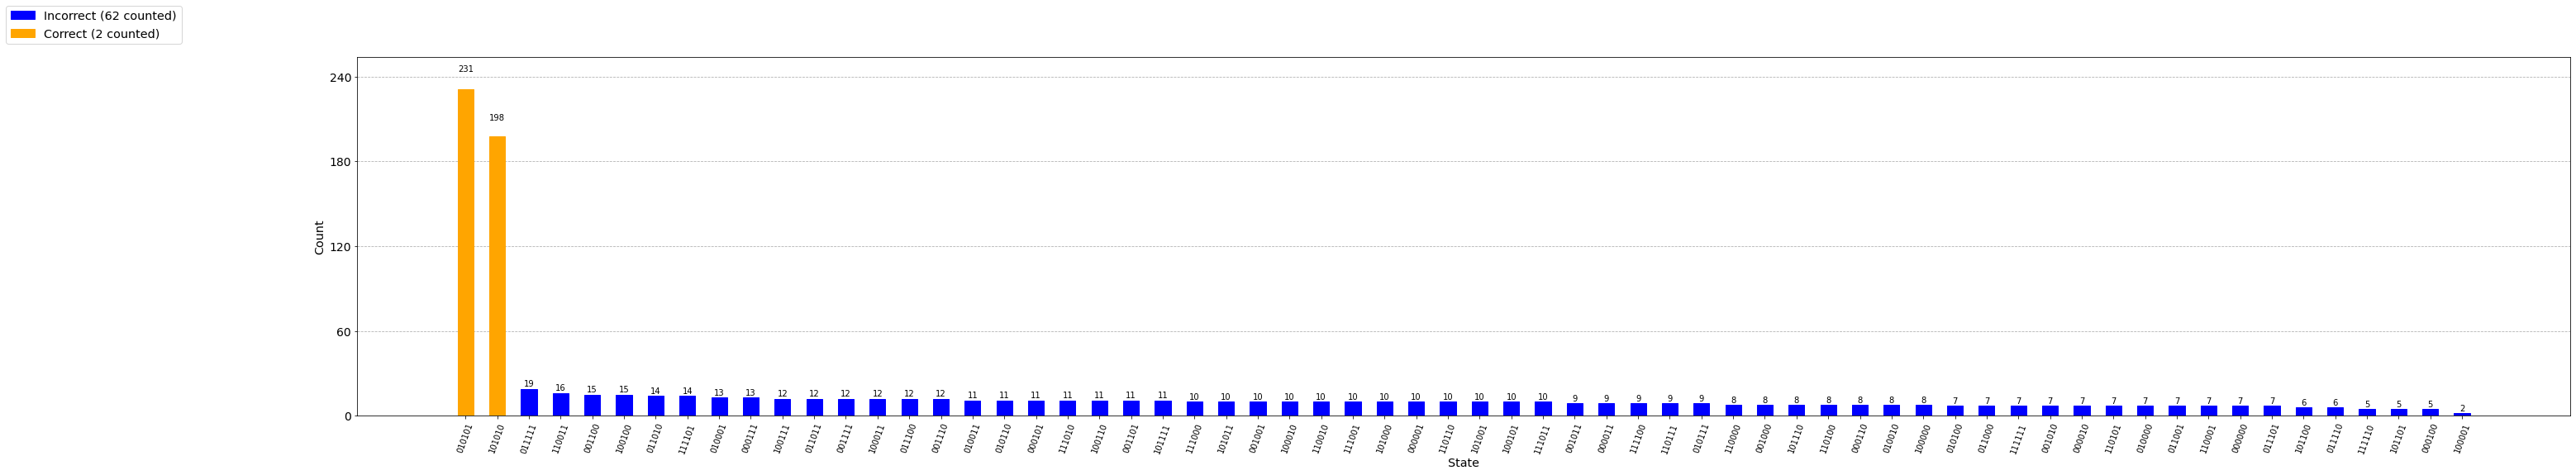

In [121]:
grover = Grover(iterations = 2, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

## **Part 2: Grover for 4 Coloring Problems**
---

In this section, we will expand upon the approach we developed in Part 1 to tackle the 4 Coloring Problem. After centuries of debate, it was proven that *any* Graph Coloring problem can be solved with 4 colors. So, being able to use Grover's algorithm to solve the 4 Coloring Problem is enough to solve *any* Graph Coloring problem with Grover's algorithm.


We will do so through these parts:

**1**: A First Approach

**2**: A Faster Approach

**3**: Beyond Coloring

---
### **Part 2.1: A First Approach**


To start, we will attempt taking a very similar approach to the one we developed above. There are two main adjustments that need to occur:

* To represent 4 possible colors per Country, we need to use *2 qubits*. So now, each Country can be in any of these four states (the colors listed below are just for sake of example): 
  * 00: White
  * 01: Red
  * 10: Orange
  * 11: Black

* To make sure that two Countries are colored differently, we will compare each digit and make sure there is at least one difference. For instance, 00 01 is ok since the 2nd digit (0 and 1) is different in each number even though the first one is the same (0). This first approach will require the use of **ancilla** (extra) qubits.

We have provided the fully updated graph coloring oracle below. Over the first few exercises, you will define the necessary functions for this to work, `disagree_multi_q` and `undo_disagree_multi_q`.

In [122]:
def graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit):

  # 1. Initializing a quantum circuit with the output bit in the |−⟩ state.
  num_vars = len(variable_qubits)
  num_checks = len(check_qubits)
  num_outputs = 1

  oracle = QuantumCircuit(num_vars + num_checks + num_outputs)
  oracle.x(output_qubit)
  oracle.h(output_qubit)


  # 2. Checking if each pair of qubits in a given list, disagree_list, disagree with each other.
  # Storing the ancilla qubits used for each check
  ancillas = []
  for i in range(len(disagree_list)):
    ancillas += [ disagree_check_4c(oracle,
                                  disagree_list[i][0], 
                                  disagree_list[i][1], 
                                  check_qubits[i]) ]

  
  # 3. Flip the output bit if all disagreements are satisfied.
  oracle.mct(check_qubits, output_qubit)


  # 4. Resetting all the extra qubits for the next iteration.
  # Need to include the specific ancillas used for each check
  for i in range(len(disagree_list)):
    undo_disagree_check_4c(oracle, 
                           disagree_list[i][0], 
                           disagree_list[i][1], 
                           check_qubits[i], 
                           ancillas[i])

  
  return oracle

#### **Exercise #1**

To start, let's work out what the `disagree_check_4c(...)` function needs to do part by part and then we can put it into a function in Exercise #2. The overall goal of this function is to flip the check qubit if at least one pair of digits disagree. We will accomplish this as follows:

1. Add 2 ancilla qubits to the circuit. This provides 1 per digit.
1. Check if the first digit of each state *agrees*.
1. Check if the second digit of each state *agrees*.
1. Flip the check bit if either *disagree*.

**To get started, run the code below. You will refer to these variables throughout this exercise.**

In [123]:
qc = QuantumCircuit(5)
qubits_a = [0, 1]
qubits_b = [2, 3]
check_qubit = 4

##### **1. Add 2 ancilla qubits to the circuit.**

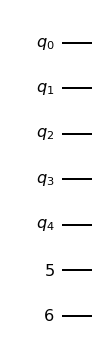

In [124]:
ancillas = [AncillaQubit(), AncillaQubit()]
qc.add_bits(ancillas)

qc.draw(output = 'mpl')

##### **2. Check if the first digit of each state agrees.**

The following information may be helpful for completing this code:
* The first digit is stored in the 0th index of each: `qubit_a[0]` and `qubit_b[0]`.
* The corresponding ancilla qubit, `ancillas[0]`, should store the result of this check.
* Checking for agreement is the same as checking for disagreement and then flipping the qubit.
* We checked for disagreement of qubits in Part 1 and have generally seen that the X gate can be used to flip qubit states.

In [ ]:
qc.cx(qubits_a[0], ancillas[0])
qc.cx(qubits_b[0], ancillas[0])
qc.x(ancillas[0])

##### **3. Check if the second digit of each state agrees.**

Do the same as above, but for the 2nd digits.

In [ ]:
qc.cx(qubits_a[1], ancillas[1])
qc.cx(qubits_b[1], ancillas[1])
qc.x(ancillas[1])

##### **4. Flip the check bit if either disagree.**

* It's easiest to first check if all the digits agree and then flip the output.
* The multi-controlled target gate allows for checking multiple qubits at once and storing the result.
* The ancillas store the results we need to check.

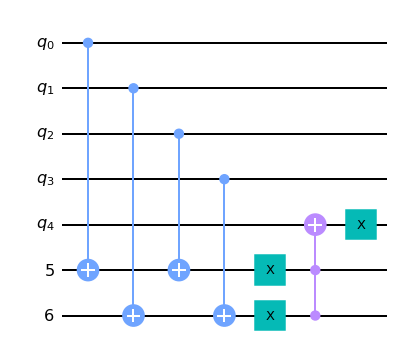

In [127]:
qc.mct(ancillas, check_qubit)
qc.x(check_qubit)

qc.draw(output = 'mpl')

##### **If you happen to be curious about why we are taking this approach**: 

To allow for one pair of digits to agree and the other to disagree using quantum circuits, we take advantage of the fact that the following two statements are the same:

1. ($q_0$ and $q_2$ disagree) OR ($q_1$ and $q_3$ disagree)

1. NOT( ($q_0$ and $q_2$ agree) AND ($q_1$ and $q_3$ agree) )

The second statement is easier to implement in quantum circuits directly because NOT can be encoded with an X gate and AND can be encoded with the multi-controlled gate (or a Toffoli since we have 2 ancilla qubits as our controls) amongst other approaches. The equivalence of those two statements is technically known as De Morgan's law.

#### **Exercise #2**

The only addition to Exercise #1 is that we must also return the ancilla qubits so that this operation can be undone (reset) for future iterations.

In [128]:
def disagree_check_4c(qc, qubits_a, qubits_b, check_qubit):

  # 1. Add 2 ancilla qubits to the circuit. This provides 1 per digit.
  ancillas = [AncillaQubit() for i in range(2)]
  qc.add_bits(ancillas)

  # 2. Check if the first digit of each state agrees.
  qc.cx(qubits_a[0], ancillas[0])
  qc.cx(qubits_b[0], ancillas[0])
  qc.x(ancillas[0])
  

  # 3. Check if the second digit of each state agrees.
  qc.cx(qubits_a[1], ancillas[1])
  qc.cx(qubits_b[1], ancillas[1])
  qc.x(ancillas[1])

  # 4. Flip the check bit if either disagree.
  qc.mct(ancillas, check_qubit)
  qc.x(check_qubit)

  # Return ancillas so that we can undo this operation later on
  return ancillas

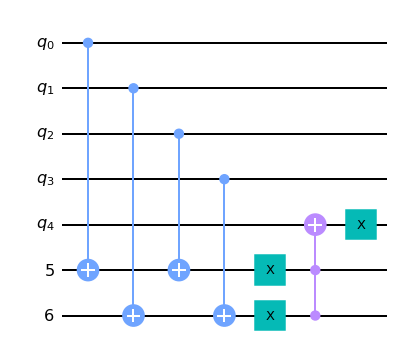

In [129]:
test = QuantumCircuit(5)
disagree_check_4c(test, [0,1], [2,3], 4)
test.draw(output='mpl')

#### **Exercise #3**

Next, we need to define the function that *undoes* this operation, `undo_disagree_check_4c(...)`. Instead of returning the ancillas, this function takes them in and uses them to make sure they get reset properly.

In [130]:
def undo_disagree_check_4c(qc, qubits_a, qubits_b, check_qubit, ancillas):

  # 4. UNDO Flip the check bit if either disagree.
  qc.x(check_qubit)
  qc.mct(ancillas, check_qubit)
  
  # 3. UNDO Check if the second digit of each state agrees.
  qc.x(ancillas[1])
  qc.cx(qubits_b[1], ancillas[1])
  qc.cx(qubits_a[1], ancillas[1])

  # 2. UNDO Check if the first digit of each state agrees.
  qc.x(ancillas[0])
  qc.cx(qubits_b[0], ancillas[0])
  qc.cx(qubits_a[0], ancillas[0])

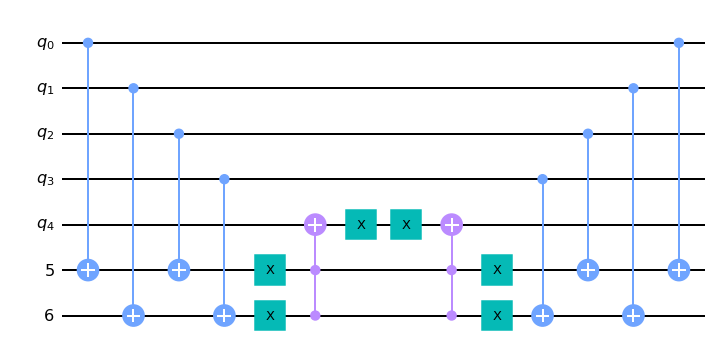

In [131]:
undo_disagree_check_4c(test, [0,1], [2,3], 4, [5,6])
test.draw(output='mpl')

#### **Exercise #4**

Lastly, we need to define an updated version of `check_disagree_list_general(...)` that accounts for the multiple digits: `check_disagree_list_general_4c(...)`.


As a reminder, this function was used for verifying the correct states as follows:
* It takes in a string representation of a measured state, called `state`.
* It takes in `disagree_list`.
* It compares every pair of bits listed in the `disagree_list`.
* If any pair of bits are the same, then the function returns `False`.
* Otherwise, the function returns `True`.

In [132]:
def check_disagree_list_general_4c(state, disagree_list):

  for i in range(len(disagree_list)):
    
    if (state[disagree_list[i][0][0]] == state[disagree_list[i][1][0]] 
        and state[disagree_list[i][0][1]] == state[disagree_list[i][1][1]]):
        return False

  return True

##### **Run the code below to verify that your function works properly.**

In [133]:
check1 = (check_disagree_list_general_4c('1111', [[[0, 1], [2, 3]]]) == False)
check2 = (check_disagree_list_general_4c('0111', [[[0, 1], [2, 3]]]) == True)
check3 = (check_disagree_list_general_4c('0110', [[[0, 1], [2, 3]]]) == True)
check4 = (check_disagree_list_general_4c('0101', [[[0, 1], [2, 3]]]) == False)

if not check1:
  print("1111 Fails")

if not check2:
  print("0111 Fails")

if not check3:
  print("0110 Fails")

if not check4:
  print("0101 Fails")

if check1 and check2 and check3 and check4:
  print("Success, keep moving!")

Success, keep moving!


#### **Exercise #5**

Let's put these functions to use! Specifically,

1. Define the problem.
1. Solve the problem.

The problem in this exercise is to color 3 countries that all border each other (something that is impossible to do with just 2 colors):

**Country 0 | Country 1**

**&emsp;&emsp;Country 2**

##### **1. Define the problem.**

**NOTE**: The biggest adjustment here is that every country must be represented by two qubits, which will effect the initial variable defintions.

In [134]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3, 4, 5]
check_qubits = [6, 7, 8]
output_qubit = 9
disagree_list = [ [[0, 1], [2, 3]],
                  [[0, 1], [4, 5]],
                  [[2, 3], [4, 5]]
                 ]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

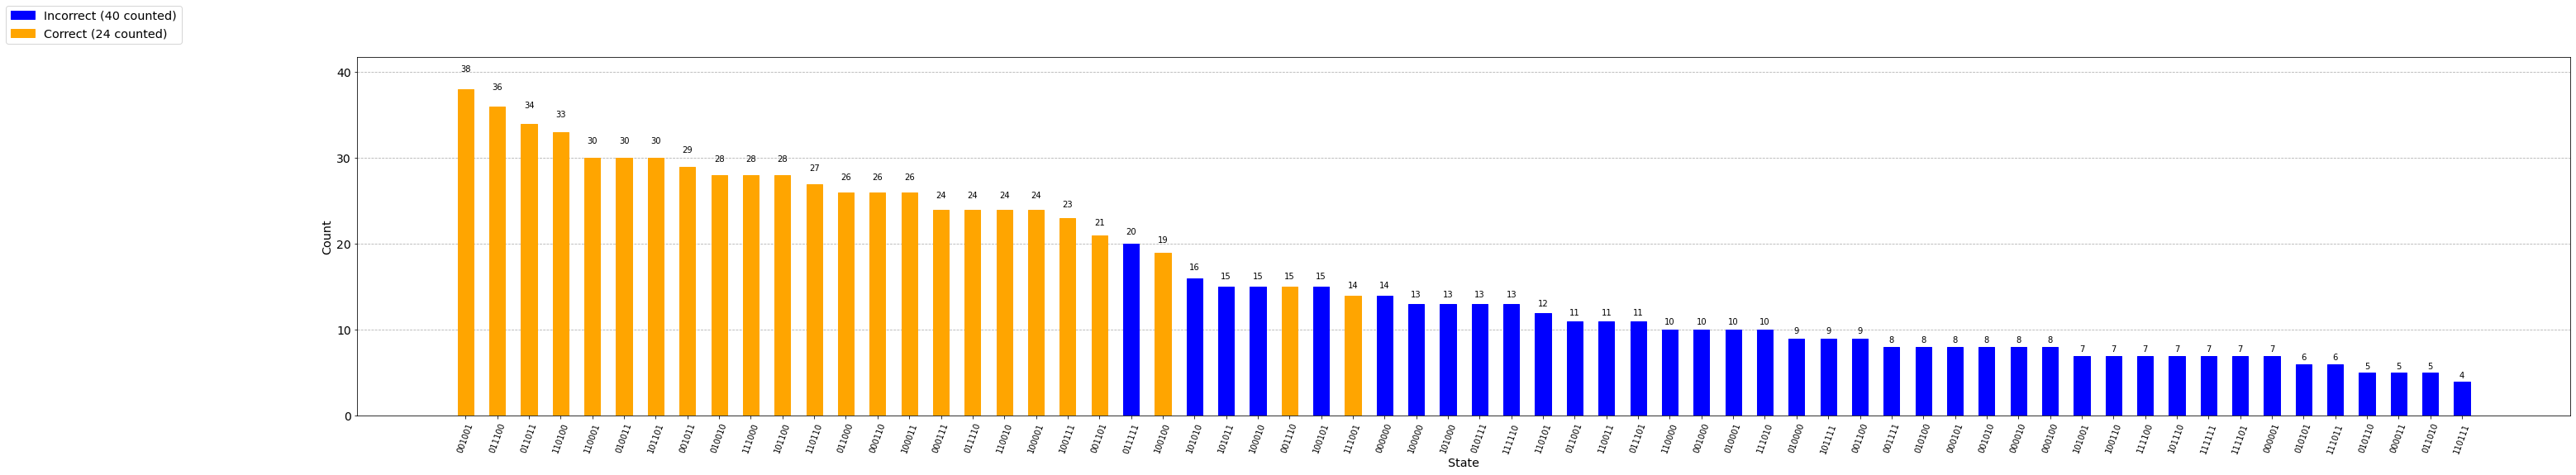

In [135]:
grover = Grover(iterations = 1, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Exercise #6**

Now, solve the problem of coloring 4 countries such that the first 2 border each other and the second two border each other, but there is water between them:

**Country 0 | Country 1 ~ ~ water ~ ~ Country 2 | Country 3**

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 2 and 3 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

**Question**: Is this problem over- or under- constrained (or is there exactly one solution)?

##### **1. Define the problem.**

In [136]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7]
check_qubits = [8, 9, 10]
output_qubit = 11
disagree_list = [ [[0, 1], [2, 3]],
                  [[4, 5], [6, 7]]
                 ]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

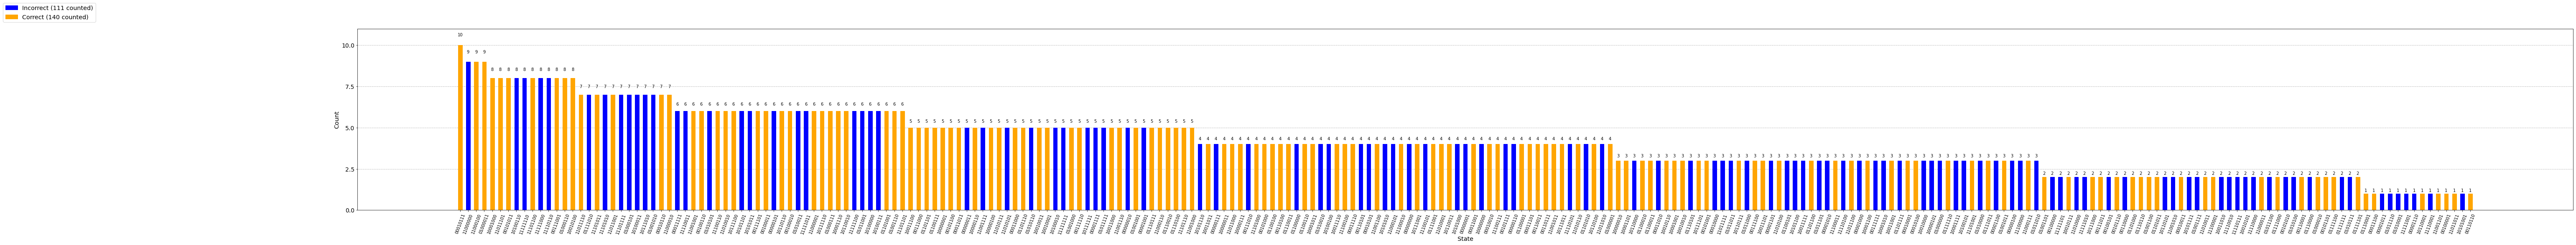

In [137]:
grover = Grover(iterations = 2, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Exercise #7**

Now, solve the problem of coloring 4 countries such that the first 3 are in the same arrangement as Exercise #5, but are now bordered on all sides by the last country:

**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<font size="6">Country 3</font>**

**<font size="6">Country 3</font> &ensp;| Country 0 | Country 1 | &ensp;<font size="6">Country 3</font>**

**&ensp;&ensp;&ensp;<font size="6">Country 3</font>&ensp;&ensp;&ensp;| Country 2 | &ensp;&ensp;&ensp;<font size="6">Country 3</font>**

**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<font size="6">Country 3</font>**


This means that:
* Countries 0 and 1 must be colored differently.
* Countries 0 and 2 must be colored differently.
* Countries 0 and 3 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 1 and 3 must be colored differently.
* Countries 2 and 3 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

**NOTE**: This is a large problem and may take several minutes to run.

##### **1. Define the problem.**

In [138]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7]
check_qubits = [8, 9, 10, 11, 12, 13]
output_qubit = 14
disagree_list = [ [[0, 1], [2, 3]],
                  [[0, 1], [4, 5]],
                  [[0, 1], [6, 7]],
                  [[2, 3], [4, 5]],
                  [[2, 3], [6, 7]],
                  [[4, 5], [6, 7]]
                 ]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

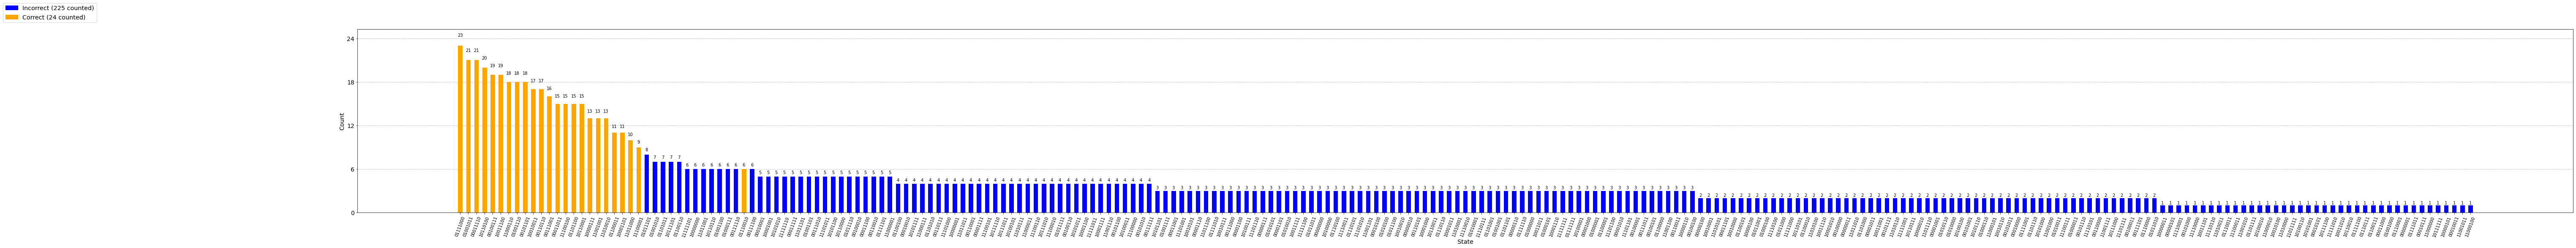

In [139]:
grover = Grover(iterations = 1, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

In [140]:
def set_up(nv, edges):
    variable_qubits = list(range(2*nv))
    check_qubits = list(range(2*nv, 2*nv+len(edges)))
    output_qubit = 2*nv + len(edges)

    disagree_list = [[[2*edge[0], 2*edge[0]+1], [2*edge[1], 2*edge[1]+1]] for edge in edges]

    return variable_qubits, check_qubits, output_qubit, disagree_list

In [141]:
variable_qubits, check_qubits, output_qubit, disagree_list = set_up(9, [[0,1], [0,2], [1,2], [2,3], [2,6], [3,6], [6,7], [6,8], [7,8], [3,4], [3,5], [4,5]])
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

In [ ]:
grover = Grover(iterations = 1, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Hitting Limits**

The code above should be able to solve this problem within just 1 - 2 iterations. However, it takes almost 2 minutes per iteration. For computers, this is an unacceptably long time, particularly given that this problem is much smaller than many of the applications we might be interested in (most directly, imagine trying to color a map of Africa or the world)!


It is common in scientific research to first find something that works, just so you know it can be done, and then find ways to optimize (improve) it. Furthermore, there are often many ways to optimize an algorithm and choosing how much time and energy to spend on the different ways largely depends on what you need to accomplish in practice.

In Part 2.2, we will explore one way to optimize this code, specifically making it run faster. We can verify that it is faster by trying it out on the exact same problem as above.

---
### **Part 2.2: A Faster Approach**


In this section, we will optimize our implementation of Grover's algorithm for the 4-coloring problem by determining one of the "bottlenecks" (parts that are slowing everything down) and attempting to improve upon it.

#### **Exercise #1**

To start, we need to understand what is actually slowing this code down, called a [bottleneck](https://en.wikipedia.org/wiki/Bottleneck_(software)). In other words, we need to diagnose the problem. 

**Draw the prep and oracle circuits from the problem above to see what we are working with.**

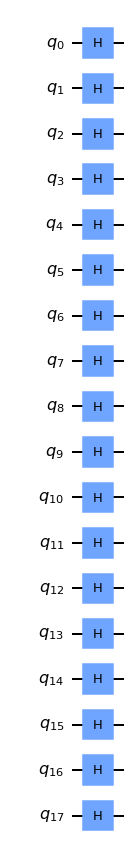

In [143]:
prep.draw(output='mpl')

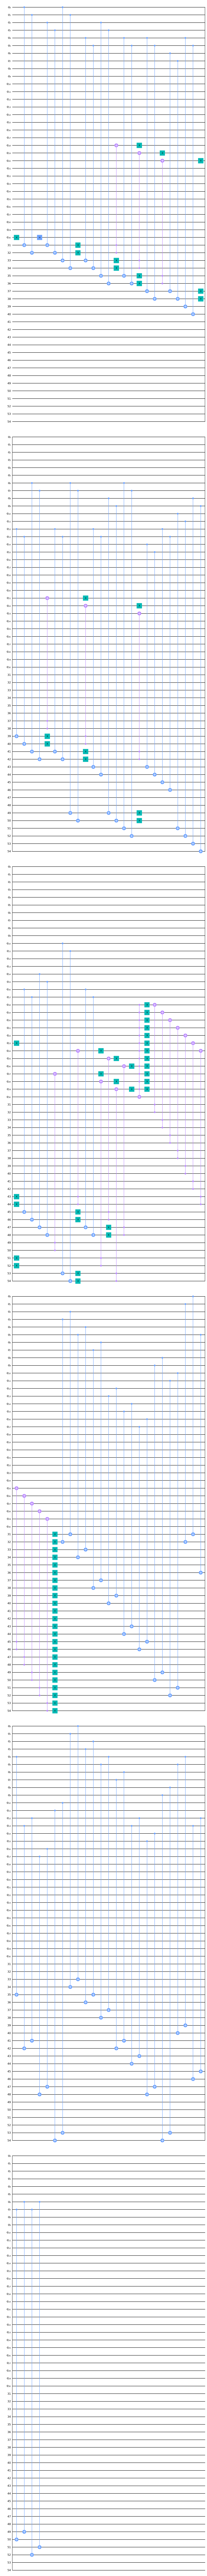

In [144]:
oracle.draw(output='mpl')

#### **Open Ended Question**

We cannot do much to change the prep circuit unless we find an entirely different way to represent the problem.

However, there's often more freedom to change the oracle circuit by representing the same logic in a different way. To see what we might change, consider the following question:

***What are different ways we could change the oracle?***

#### **Exercise #2**

The particular way we will optimize the oracle here is to eliminate the need for ancilla qubits as they effectively double the size and complexity of the problem. For instance, the last problem from Part 2.1 had 12 ancilla qubits on top of the 14 "core" qubits.

<br>

To accomplish this, we will approach the disagreement checks completely differently. The logic we used before was very generallly encoding the idea of pairs of qubits disagreeing. However, with 4 colors it turns out that there are only ever 4 cases where all 4 qubits agree with each other. Here are the 4 cases explicitly:

11 11

01 01

10 10

00 00

All (12) other states are acceptable! So, we've been using general logic to eliminate 4/16 or just 1/4 of the possibilities. Instead, let us specifically target these states as follows:

1. Check if the qubits are in the 11 11 state.
2. Check if the qubits are in the 01 01 state.
3. Check if the qubits are in the 10 10 state.
4. Check if the qubits are in the 00 00 state.
5. If none of these states have been found, flip the output qubit.


In [145]:
qc = QuantumCircuit(5)
qubits_a = [0, 1]
qubits_b = [2, 3]
check_qubit = 4

##### **1. Check if the qubits are in the 11 11 state.**

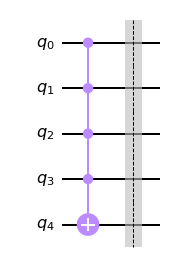

In [146]:
qc.mct(qubits_a + qubits_b, check_qubit)

qc.barrier()
qc.draw(output='mpl')

##### **2. Check if the qubits are in the 01 01 state.**

This is a matter of modifying the approach above by flipping the appropriate qubits AND making sure that you undo any flips *right* after checking so that they are ready to be checked for the next case.

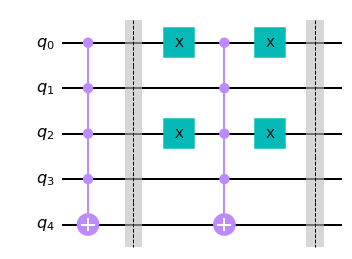

In [147]:
qc.x([i for i in range(0,check_qubit,2)])
qc.mct(qubits_a + qubits_b, check_qubit)
qc.x([i for i in range(0,check_qubit,2)])
qc.barrier()
qc.draw(output='mpl')

##### **3. Check if the qubits are in the 10 10 state.**

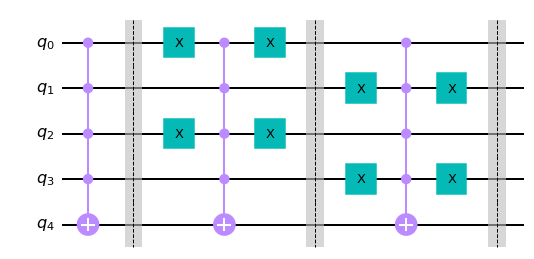

In [148]:
qc.x([i for i in range(1,check_qubit,2)])
qc.mct(qubits_a + qubits_b, check_qubit)
qc.x([i for i in range(1,check_qubit,2)])
qc.barrier()
qc.draw(output='mpl')

##### **4. Check if the qubits are in the 00 00 state.**

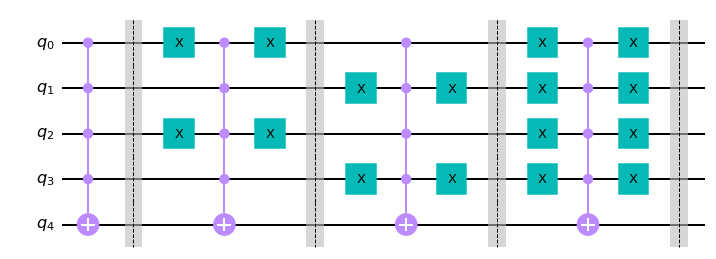

In [149]:
qc.x([i for i in range(0,check_qubit,1)])
qc.mct(qubits_a + qubits_b, check_qubit)
qc.x([i for i in range(0,check_qubit,1)])
qc.barrier()
qc.draw(output='mpl')

##### **5. If none of these states have been found, flip the output qubit.**

Now all 4 states have been checked and $q_4$ will be 1 if any of them have been found. However, we want to flip this logic so that $q_4$ is 1 if *none* of them have been found.

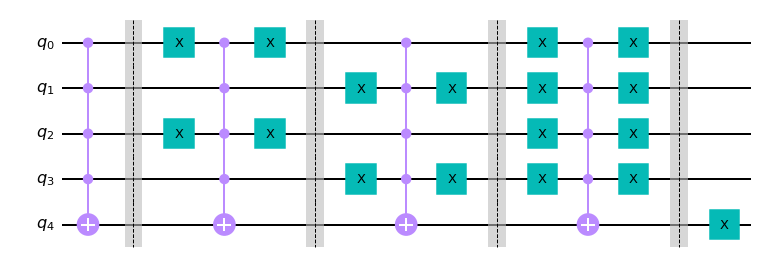

In [150]:
qc.x(check_qubit)

qc.draw(output='mpl')

#### **6. the circuit can be improved by removing redundant 8 of the total 16 x-gates which shown in below code:**

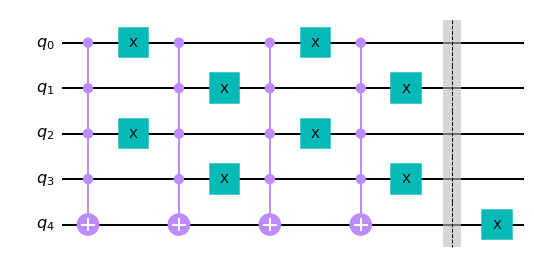

In [151]:
qc = QuantumCircuit(5)
qubits_a = [0, 1]
qubits_b = [2, 3]
check_qubit = 4

# 1. Check if the qubits are in the 11 11 state.
qc.mct(qubits_a+qubits_b, check_qubit)
qc.x([qubits_a[0], qubits_b[0]])

# 2. Check if the qubits are in the 01 01 state.
qc.mct(qubits_a+qubits_b, check_qubit)
qc.x([qubits_a[1],qubits_b[1]])

# 3. Check if the qubits are in the 00 00 state.
qc.mct(qubits_a+qubits_b, check_qubit)
qc.x([qubits_a[0], qubits_b[0]])

# 4. Check if the qubits are in the 10 10 state.
qc.mct(qubits_a+qubits_b, check_qubit)
qc.x([qubits_a[1], qubits_b[1]])

qc.barrier()

# 5. If none of these states have been found, flip the output qubit.
qc.x(check_qubit)

qc.draw(output='mpl')

#### **Exercise #3**

In [152]:
def disagree_check_4c(qc, qubits_a, qubits_b, check_qubit):
  
  # 1. Check if the qubits are in the 11 11 state.
  qc.mct(qubits_a+qubits_b, check_qubit)
  qc.x([qubits_a[0], qubits_b[0]])

  # 2. Check if the qubits are in the 01 01 state.
  qc.mct(qubits_a+qubits_b, check_qubit)
  qc.x([qubits_a[1],qubits_b[1]])

  # 3. Check if the qubits are in the 00 00 state.
  qc.mct(qubits_a+qubits_b, check_qubit)
  qc.x([qubits_a[0], qubits_b[0]])

  # 4. Check if the qubits are in the 10 10 state.
  qc.mct(qubits_a+qubits_b, check_qubit)
  qc.x([qubits_a[1], qubits_b[1]])

  # 5. If none of these states have been found, flip the output qubit.
  qc.x(check_qubit)

#### **Exercise #4**

Lastly, we need to define the function that *undoes* this operation, `undo_disagree_check_4c(...)`.

In [153]:
def undo_disagree_check_4c(qc, qubits_a, qubits_b, check_qubit):

  # 5. UNDO If none of these states have been found, flip the output qubit.
  qc.x(check_qubit)

  # 4. UNDO Check if the qubits are in the 10 10 state.
  qc.x([qubits_a[1], qubits_b[1]])
  qc.mct(qubits_a+qubits_b, check_qubit)

  # 3. UNDO Check if the qubits are in the 00 00 state.
  qc.x([qubits_a[0], qubits_b[0]])
  qc.mct(qubits_a+qubits_b, check_qubit)

  # 2. UNDO Check if the qubits are in the 01 01 state.
  qc.x([qubits_a[1], qubits_b[1]])
  qc.mct(qubits_a+qubits_b, check_qubit)

  # 1. UNDO Check if the qubits are in the 11 11 state.
  qc.x([qubits_a[0], qubits_b[0]])
  qc.mct(qubits_a+qubits_b, check_qubit)

#### **Updating the Oracle Function**

Now that we are not using ancilla qubits, we need to slightly update the oracle function.

In [154]:
def graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit):

  # 1. Initializing a quantum circuit with the output bit in the |−⟩ state.
  num_vars = len(variable_qubits)
  num_checks = len(check_qubits)
  num_outputs = 1

  oracle = QuantumCircuit(num_vars + num_checks + num_outputs)
  oracle.x(output_qubit)
  oracle.h(output_qubit)


  # 2. Checking if each pair of qubits in a given list, disagree_list, disagree with each other.
  for i in range(len(disagree_list)):
    disagree_check_4c(oracle,
                      disagree_list[i][0], 
                      disagree_list[i][1], 
                      check_qubits[i])

  
  # 3. Flip the output bit if all disagreements are satisfied.
  oracle.mct(check_qubits, output_qubit)


  # 4. Resetting all the extra qubits for the next iteration.
  # Need to include the specific ancillas used for each check
  for i in range(len(disagree_list)):
    undo_disagree_check_4c(oracle, 
                           disagree_list[i][0], 
                           disagree_list[i][1], 
                           check_qubits[i])

  
  return oracle

#### **Exercise #5**

Now, solve the problem from the last exercise of Part 2.1.

As a reminder, it is the problem of coloring 4 countries such that the first 3 are in the same arrangement as Exercise #5, but are now bordered on all sides by the last country:

**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<font size="6">Country 3</font>**

**<font size="6">Country 3</font> &ensp;| Country 0 | Country 1 | &ensp;<font size="6">Country 3</font>**

**&ensp;&ensp;&ensp;<font size="6">Country 3</font>&ensp;&ensp;&ensp;| Country 2 | &ensp;&ensp;&ensp;<font size="6">Country 3</font>**

**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<font size="6">Country 3</font>**


<br>

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 0 and 2 must be colored differently.
* Countries 0 and 3 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 1 and 3 must be colored differently.
* Countries 2 and 3 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

##### **1. Define the problem.**

In [155]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7]
check_qubits = [8, 9, 10, 11, 12, 13]
output_qubit = 14
disagree_list = [ [[0, 1], [2, 3]],
                  [[0, 1], [4, 5]],
                  [[0, 1], [6, 7]],
                  [[2, 3], [4, 5]],
                  [[2, 3], [6, 7]],
                  [[4, 5], [6, 7]]
                 ]

# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

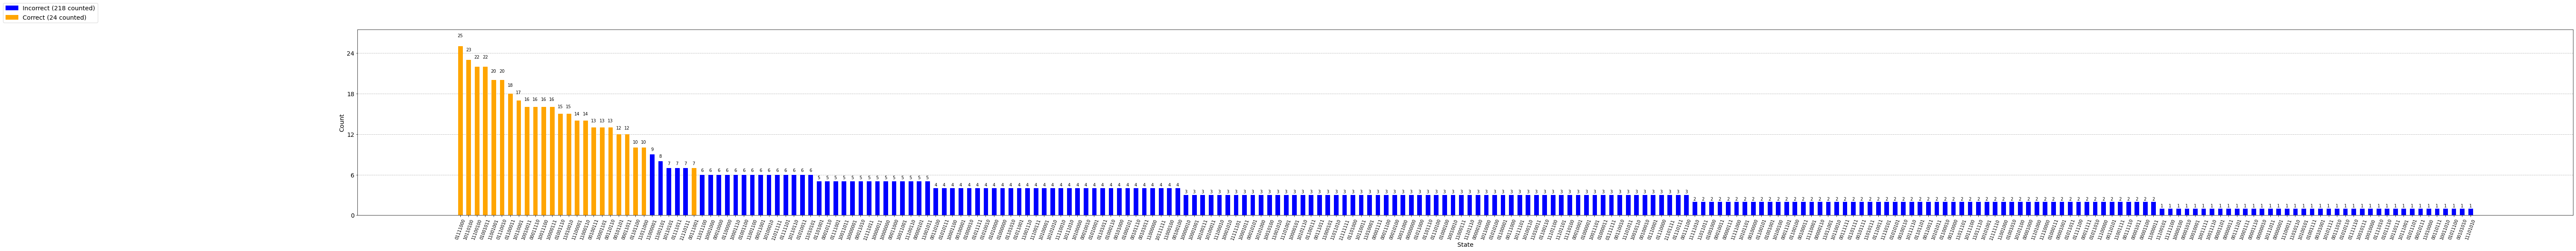

In [156]:
grover = Grover(iterations = 1, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

In [157]:
variable_qubits, check_qubits, output_qubit, disagree_list = set_up(9, [[0,1], [0,2], [1,2], [2,3], [2,6], [3,6], [6,7], [6,8], [7,8], [3,4], [3,5], [4,5]])
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

In [ ]:
grover = Grover(iterations = 1, quantum_instance = AerSimulator(method='extended_stabilizer'))

results = grover.amplify(problem)

plot_results(results, check_disagreement)

---
### **Part 2.3: Beyond Coloring**


Now that we have found a faster way to solve the 4 Coloring problem, let's explore applications of this algorithm beyond the Coloring problem itself. In particular, we will look at **scheduling problems** framed as follows:

> Given a schedule of flying routes and $k$ airplanes that are available to fly, create an assignment of airplanes to flights and timeslots.

<br>


For example the following table shows $k = 4$ planes and 4 total routes to be assigned a plane:

| **Time \| Route** | **Boston to DC (2 hours)** | **DC to Los Angeles (6 hours)** |
|------------------|----------------------------|-------------------------------------|
| **9 am**         | Route 0    | Route 1             |
| **12 pm**        | Route 2    | Route 3             |


<br>

Two possible solutions to this specific problem are:

| **Time \| Route** | **Boston to DC (2 hours)** | **DC to Los Angeles (6 hours)** |
|------------------|----------------------------|-------------------------------------|
| **9 am**         | Airplane 0                 | Airplane 1                          |
| **12 pm**        | Airplane 2                 | Airplane 3                          |


<br>


| **Time \| Route** | **Boston to DC (2 hours)** | **DC to Los Angeles (6 hours)** |
|------------------|----------------------------|-------------------------------------|
| **9 am**         | Airplane 0                 | Airplane 1                          |
| **12 pm**        | Airplane 2                 | Airplane 0                          |



<br>

Most importantly, we can use Graph Coloring to solve this problem! This just requires thinking of the problem as follows:
* Instead of $k$ colors, we have $k$ airplanes.
* Instead of borders, we have restrictions based on the fact that each airplane can only fly one route at a time. In particular, this means:
  * Any airplanes taking off at the same time must be different.
  * An airplane can be used for multiple routes, but only if it has landed after any previous flights. So, the takeoff times and route times must be considered.

#### **Exercise #1**

Let's solve the problem given above and restated here:

| **Time \| Route** | **Boston to DC (2 hours)** | **DC to Los Angeles (6 hours)** |
|------------------|----------------------------|-------------------------------------|
| **9 am**         | Route 0    | Route 1             |
| **12 pm**        | Route 2    | Route 3             |

<br>

Since there are 4 possible planes to use, this is fundamentally a 4 Coloring Problem. So, we can use our Grover solver from above.

The key to doing this is encoding the restrictions correctly:
* Route 0 and Route 1 must use different planes since they take off at the same time.
* Route 0 and Route 2 must use different planes since the plane flying Route 0 will not have time to return to Boston for Route 2.
* Route 1 and Route 2 must use different planes since the plane flying Route 1 will still be in the air when Route 2 is meant to start.
* Route 1 and Route 3 must use different planes for the same reason.
* Route 2 and 3 must use different planes since they take off at the same time.
* The only acceptable reuse of a plane is for Route 0 and 3 since the plane flying Route 0 will have been able to land in DC before Route 3 takes off.

##### **1. Define the problem.**

Complete the code below to define this specific problem.

In [160]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7]
check_qubits = [8, 9, 10, 11, 12]
output_qubit = 13
disagree_list = [ [[0, 1], [2, 3]],
                  [[0, 1], [4, 5]],
                  [[2, 3], [4, 5]],
                  [[2, 3], [6, 7]],
                  [[4, 5], [6, 7]]
                 ]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

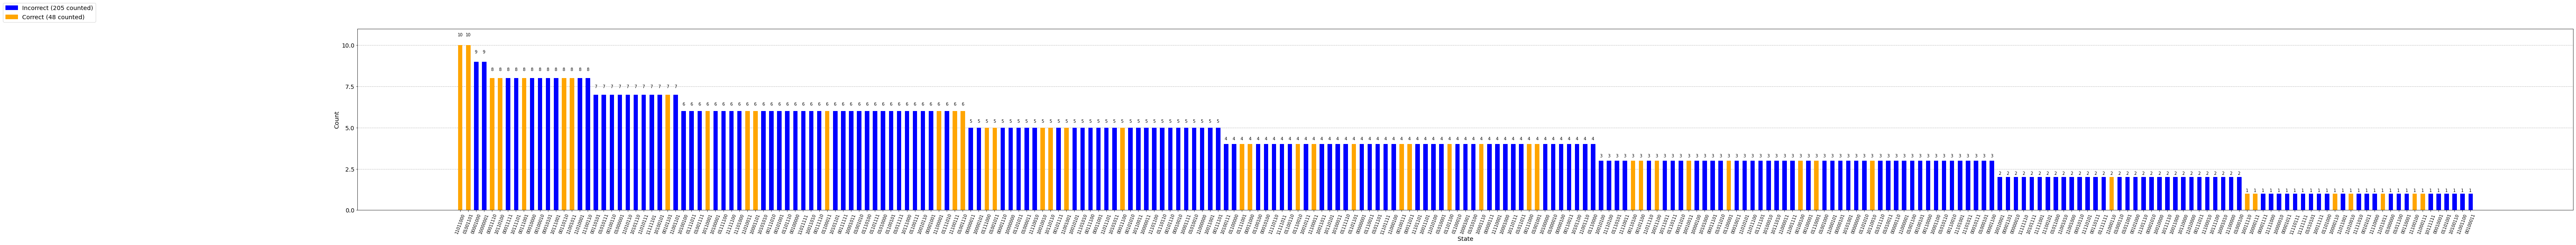

In [161]:
grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Exercise #2**

Now, let's solve a bigger problem:

| **Time \| Route** | **Boston to DC (2 hours)** | **DC to Los Angeles (6 hours)** |
|-------------------|----------------------------|---------------------------------|
| **9 am**          | Route 0                    | Route 1                         |
| **12 pm**         | Route 2                    | Route 3                         |
| **3 pm**          | Route 4                    | Route 5                         |

<br>

The restrictions are the same as above, but now include:
* Route 1 and Route 4 must use different planes since the plane flying Route 1 will have just landed in Los Angeles and so cannot takeoff from Boston.
* Route 1 and Route 5 must use different planes for the same reason.
* Route 2 and Route 3 must use different planes since they take off at the same time.
* Route 2 and Route 4 must use different planes since the plane flying Route 2 will not have time to return to Boston for Route 4.
* Route 3 and Route 4 must use different planes since the plane flying Route 3 will still be in the air when Route 4 is meant to start.
* Route 3 and Route 5 must use different planes for the same reason.
* Route 4 and 5 must use different planes since they take off at the same time.

<br>

**NOTE**: The size of the problem and the fact there's multiple correct solutions means this problem may take a long time to run and, even more so, to solve well. As such it is ok if you do not get perfect results for this problem. Rather, we leave it to you to continue on after completing the project notebook to determine a way to get around these problems. This could include:
* Using a more efficient simulator.
* Considering if any variables can be removed from the problem. For instance, a Route that cannot overlap with *any* other Route can be assigned a plane and then both that Route and plane can be completely removed from the problem (meaning it is now a 3 Coloring Problem).
* Redefining the way we use Grover's algorithm.

##### **1. Define the problem.**

In [162]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
check_qubits = [12, 13, 14, 15, 16, 17, 18]
output_qubit = 19
disagree_list = [ [[2, 3], [8, 9]],
                  [[2, 3], [10, 11]],
                  [[4, 5], [6, 7]],
                  [[4, 5], [8, 9]],
                  [[6, 7], [8, 9]],
                  [[6, 7], [10, 11]],
                  [[8, 9], [10, 11]]
                 ]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle_4c(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general_4c(state, disagree_list)

problem = AmplificationProblem(oracle, 
                               state_preparation = prep,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

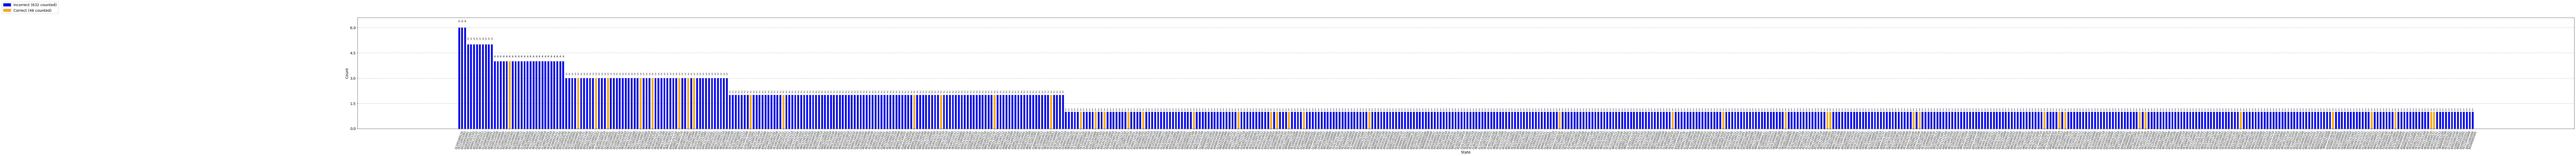

In [169]:
grover = Grover(iterations = 7, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)